In [1]:
import pandas as pd
import numpy as np
from recmetrics.plots import LongTailPlot, MarkPlot, CoveragePlot
from recmetrics.metrics import mark, coverage, personalization, intra_list_similarity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

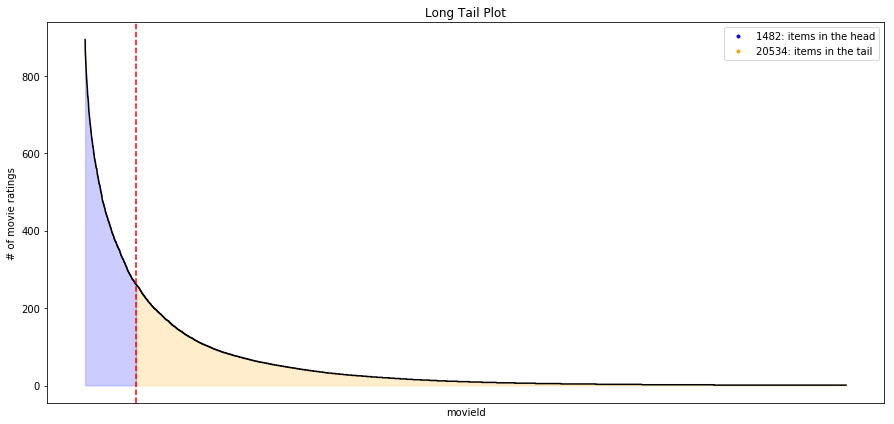

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

## test/train split

In [7]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[524, 1282, 4622, 3600, 1556, 3093, 24, 3101, ..."
208,"[1544, 14, 2575, 72720, 26712, 1046, 2585, 29,..."
359,"[69640, 524, 1037, 4638, 1968, 1061, 27722, 16..."
394,"[4105, 47629, 56848, 5650, 6062, 8623, 541, 20..."
572,"[1, 111617, 69640, 3087, 5650, 39444, 7707, 31..."


In [8]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [9]:
#make recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
156,"[524, 1282, 4622, 3600, 1556, 3093, 24, 3101, ...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12..."
208,"[1544, 14, 2575, 72720, 26712, 1046, 2585, 29,...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12..."
359,"[69640, 524, 1037, 4638, 1968, 1061, 27722, 16...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12..."
394,"[4105, 47629, 56848, 5650, 6062, 8623, 541, 20...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12..."
572,"[1, 111617, 69640, 3087, 5650, 39444, 7707, 31...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12..."


In [10]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [11]:
#make recommendations for all members in the test data

recs = []
for user in test.index.tolist():
    random_predictions = train_long.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions
userId,,,
156,"[524, 1282, 4622, 3600, 1556, 3093, 24, 3101, ...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[3475, 46965, 4682, 4223, 52975, 535, 4336, 40..."
208,"[1544, 14, 2575, 72720, 26712, 1046, 2585, 29,...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[5943, 59369, 3088, 3016, 3499, 1025, 1594, 15..."
359,"[69640, 524, 1037, 4638, 1968, 1061, 27722, 16...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[99832, 50658, 5945, 1240, 38886, 5791, 3256, ..."
394,"[4105, 47629, 56848, 5650, 6062, 8623, 541, 20...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[912, 73168, 8711, 63876, 1831, 33072, 6709, 8..."
572,"[1, 111617, 69640, 3087, 5650, 39444, 7707, 31...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[2221, 69986, 74916, 2571, 9013, 3160, 49651, ..."


In [12]:
random_predictions = test.random_predictions.values.tolist()

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [13]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131168,131174,131176,131231,131239,131241,131243,131248,131254,131256
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,0.0,3.0,3.0,4.0,4.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [15]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131168,131174,131176,131231,131239,131241,131243,131248,131254,131256
156,2.971144,4.002627,1.063775,2.464281,1.539359,3.757866,3.502234,0.724789,1.841178,3.150718,...,-0.040855,-0.025221,-0.032427,-0.027567,-0.000213,-0.000213,-0.000213,-0.000213,-0.000213,-0.000213
208,4.127231,-0.164173,0.089002,0.454244,0.066338,1.517779,0.540115,-0.101938,0.299258,-0.082022,...,-0.015437,0.008285,0.010653,0.041431,-0.021310,-0.021310,-0.021310,-0.021310,-0.021310,-0.021310
359,4.028939,2.059063,0.440158,-0.424780,0.302826,4.519847,1.334106,-0.040256,0.176671,2.252665,...,-0.004970,-0.025570,-0.032876,-0.008475,-0.007442,-0.007442,-0.007442,-0.007442,-0.007442,-0.007442
394,3.272752,0.296073,0.022616,0.129549,0.509804,1.598241,-0.155136,0.027917,0.192891,1.165329,...,-0.014047,-0.010985,-0.014124,-0.043317,-0.032791,-0.032791,-0.032791,-0.032791,-0.032791,-0.032791
572,2.570895,2.058950,2.664985,0.138340,2.009729,2.028119,0.060789,0.158625,-0.177021,1.420638,...,0.017751,0.014154,0.018197,-0.062526,0.019140,0.019140,0.019140,0.019140,0.019140,0.019140


In [16]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [17]:
get_users_predictions(156, 10, cf_model, train_long)

[2802, 4018, 1586, 2316, 3708, 3494, 1580, 1544, 3763, 4855]

In [18]:
#make recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions,cf_predictions
userId,,,,
156,"[524, 1282, 4622, 3600, 1556, 3093, 24, 3101, ...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[3475, 46965, 4682, 4223, 52975, 535, 4336, 40...","[2802, 4018, 1586, 2316, 3708, 3494, 1580, 154..."
208,"[1544, 14, 2575, 72720, 26712, 1046, 2585, 29,...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[5943, 59369, 3088, 3016, 3499, 1025, 1594, 15...","[1077, 3424, 6711, 3481, 3152, 1296, 3362, 515..."
359,"[69640, 524, 1037, 4638, 1968, 1061, 27722, 16...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[99832, 50658, 5945, 1240, 38886, 5791, 3256, ...","[1213, 1240, 2000, 36529, 1270, 34048, 648, 47..."
394,"[4105, 47629, 56848, 5650, 6062, 8623, 541, 20...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[912, 73168, 8711, 63876, 1831, 33072, 6709, 8...","[541, 3260, 720, 6440, 1235, 3996, 7566, 2174,..."
572,"[1, 111617, 69640, 3087, 5650, 39444, 7707, 31...","[1198, 593, 1270, 318, 2762, 296, 260, 608, 12...","[2221, 69986, 74916, 2571, 9013, 3160, 49651, ...","[1584, 4085, 3006, 2011, 2804, 40819, 1500, 89..."


In [19]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [20]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007502679528403,
 0.0010878885316184352,
 0.0013522686673812076,
 0.0015264380135762772,
 0.0017300821722043588,
 0.0018729903536977492,
 0.0020138569897412343,
 0.00212907671107028,
 0.0022410214532401027,
 0.0023224791166913355]

In [21]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.00025723472668810293,
 0.0003483386923901393,
 0.0004233654876741693,
 0.0004930332261521972,
 0.0005487674169346196,
 0.0006005716327259736,
 0.000638850609911703,
 0.000671004950747716,
 0.000700777488558839,
 0.0007265009612276494]

In [22]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.007867095391211146,
 0.014501607717041799,
 0.020535905680600215,
 0.0262566988210075,
 0.03172508038585209,
 0.03666077170418006,
 0.04140889603429797,
 0.045730975348338684,
 0.049743122543765624,
 0.053716327259735616]

# Mark Plot

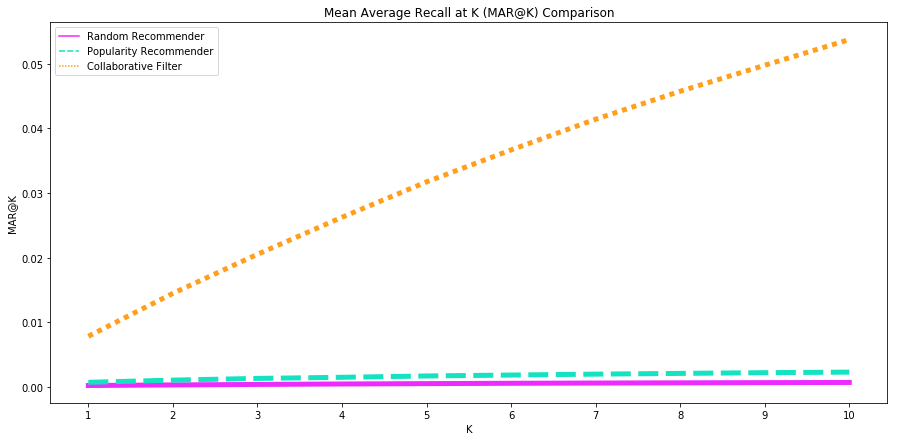

In [23]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [24]:
catalog = train_long.movieId.unique().tolist()
random_coverage = coverage(random_predictions, catalog)
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)

# Coverage Plot

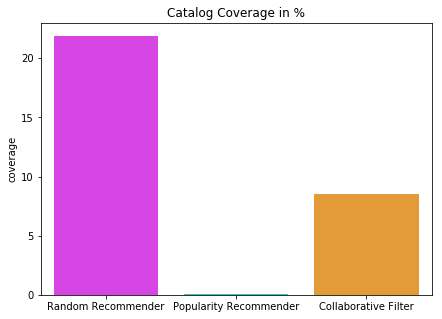

In [25]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

# Personalization

In [26]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [27]:
personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [28]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [29]:
intra_list_similarity(predicted=example_predictions, feature_df=movies[['Action', 'Comedy', 'Romance']])

0.27777777777777773